<a href="https://colab.research.google.com/github/lingmHVAC/lingmHVAC/blob/main/MomentsCalibration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Final APS mean diameter: 0.525 µm
Final APS geometric mean: 0.431 µm
Final APS mode diameter: 0.431 µm
Final APS total number: 7844 /cm³


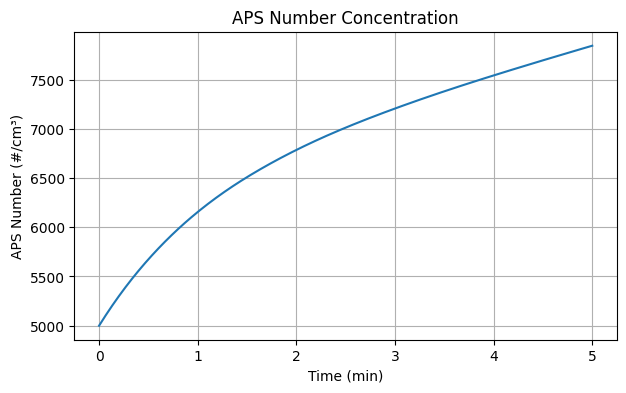

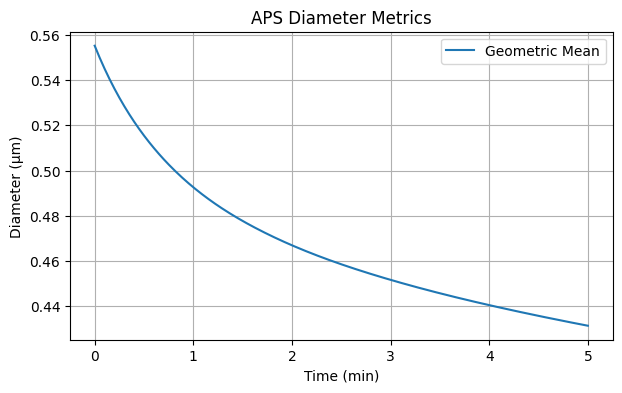

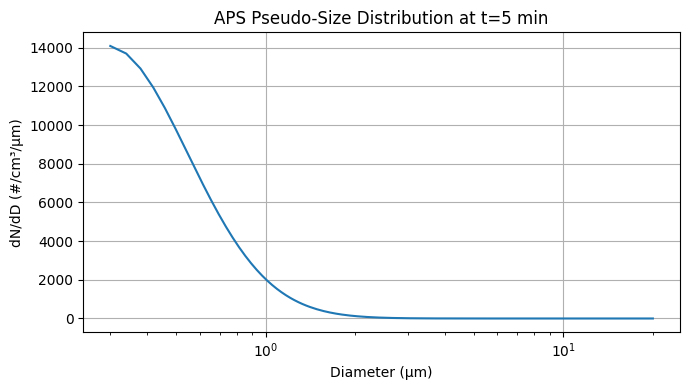

In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# ============================================================
# APS PARAMETERS & PHYSICAL CONSTANTS
# ============================================================
D_min = 0.3   # µm, counting starts
D_cut = 0.54  # µm, reliable sizing
D_max = 20.0  # µm

# Effective entry diameter for sub-APS flux
d_entry = 0.35  # µm

# Coagulation kernel (small perturbation)
K = 1e-9  # cm^3/s

# Sedimentation coefficient (simplified)
beta = 1e-3  # s^-1 µm^-2

# APS detection volume height (for settling)
H = 1.0  # m

# ============================================================
# MOMENT ODE SYSTEM
# y = [N_sub, M0, M1, M2, M3]
# ============================================================

def moment_odes(t, y, J_sub, alpha, beta):
    Nsub, M0, M1, M2, M3 = y

    # prevent negative moments
    M0 = max(M0, 0.0)
    Nsub = max(Nsub, 0.0)

    # sedimentation removal (using M2/M0 as effective diameter)
    Lambda = beta * (M2 / M0) if M0>0 else 0.0

    # Sub-APS population
    dNsub = J_sub - alpha * Nsub

    # APS-visible moments
    dM0 = alpha * Nsub - Lambda * M0 - 0.5*K*M0**2
    dM1 = alpha * Nsub * d_entry - Lambda * M1
    dM2 = alpha * Nsub * d_entry**2 - Lambda * M2 + K*M1**2
    dM3 = alpha * Nsub * d_entry**3 - Lambda * M3 + 3*K*M1*M2

    return [dNsub, dM0, dM1, dM2, dM3]

# ============================================================
# INITIAL CONDITIONS (10 min APS data)
# ============================================================
Nsub_0 = 2000.0        # /cm³, sub-APS reservoir
M0_0 = 5000.0          # APS number concentration
M1_0 = 3327.0
M2_0 = 3180.0
M3_0 = 8641.0

y0 = [Nsub_0, M0_0, M1_0, M2_0, M3_0]

# ============================================================
# CALIBRATION OF J_sub and alpha from 10→15 min data
# ============================================================
# Observed number increase in 0.3–0.54 µm bin
delta_N = 5789 - 3431  # /cm³
t_window = 5*60        # seconds
J_sub = delta_N / t_window  # ≈ 2358 / 300 s ≈ 7.86 /cm³/s
alpha = 0.015              # s^-1, calibrated transfer to APS

# ============================================================
# TIME INTEGRATION
# ============================================================
t_span = (0, 300)  # seconds (5 min window)
t_eval = np.linspace(*t_span, 300)

sol = solve_ivp(moment_odes, t_span, y0, t_eval=t_eval, args=(J_sub, alpha, beta))

Nsub, M0, M1, M2, M3 = sol.y

# Mean & geometric mean diameters
dmean = M1 / M0
dgeo = np.exp(np.log(M1/M0) - 0.5*np.log(M2/M0 / (M1/M0)**2))
# Mode from lognormal approximation
sigma = np.sqrt(np.log(M2/M0 / (M1/M0)**2))
mu = np.log(M1/M0) - 0.5*sigma**2
mode = np.exp(mu)

# ============================================================
# APS pseudo-size distribution (lognormal reconstruction)
# ============================================================
def lognormal_pdf(M0, M1, M2, M3, D_grid):
    if M0 <= 0:
        return np.zeros_like(D_grid)
    # lognormal parameters
    gmean = M1/M0
    variance = M2/M0 - gmean**2
    sigma = np.sqrt(np.log(1 + variance/gmean**2))
    mu = np.log(gmean) - 0.5*sigma**2
    pdf = M0 * lognorm.pdf(D_grid, s=sigma, scale=np.exp(mu))
    return pdf

D_grid = np.linspace(D_min, D_max, 500)
pdf_final = lognormal_pdf(M0[-1], M1[-1], M2[-1], M3[-1], D_grid)

# ============================================================
# RESULTS
# ============================================================
print(f"Final APS mean diameter: {dmean[-1]:.3f} µm")
print(f"Final APS geometric mean: {dgeo[-1]:.3f} µm")
print(f"Final APS mode diameter: {mode[-1]:.3f} µm")
print(f"Final APS total number: {M0[-1]:.0f} /cm³")

# ============================================================
# PLOTTING
# ============================================================
plt.figure(figsize=(7,4))
plt.plot(t_eval/60, M0)
plt.xlabel("Time (min)")
plt.ylabel("APS Number (#/cm³)")
plt.title("APS Number Concentration")
plt.grid()

plt.figure(figsize=(7,4))
#plt.plot(t_eval/60, dmean, label='Mean')
plt.plot(t_eval/60, dgeo, label='Geometric Mean')
#plt.plot(t_eval/60, mode*np.ones_like(t_eval), '--', label='Mode (approx)')
plt.xlabel("Time (min)")
plt.ylabel("Diameter (µm)")
plt.title("APS Diameter Metrics")
plt.legend()
plt.grid()

plt.figure(figsize=(7,4))
plt.plot(D_grid, pdf_final)
plt.xlabel("Diameter (µm)")
plt.ylabel("dN/dD (#/cm³/µm)")
plt.title("APS Pseudo-Size Distribution at t=5 min")
plt.grid()
plt.xscale('log')

plt.tight_layout()
plt.show()
